In [1]:
import random
import torch
import copy
import gc

import pandas as pd

from tqdm.notebook import tqdm

from gensim.test.utils import datapath

from scipy.stats import pearsonr, spearmanr, kendalltau

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

import matplotlib.pyplot as plt
from matplotlib import colormaps as clmp
from matplotlib.ticker import AutoMinorLocator

In [2]:
datapath('wordsim353.tsv')

'/home/daviderigamonti/Thesis/nlp-thesis/lib/python3.10/site-packages/gensim/test/test_data/wordsim353.tsv'

# Import Models

In [2]:
noadd = lambda x: x
addspace = lambda x: " " + x
addall = lambda x: (x.capitalize(), " " + x.capitalize(), x.lower(), " " + x.lower())

In [35]:
model_info = [
    {"id": "gpt2", "name": "GPT 2", "voc_size": 50257, "emb_size": 768, "format": addspace},
    {"id": "meta-llama/Llama-2-7b-hf", "name": "LLaMa 2", "voc_size": 32000, "emb_size": 5120, "format": noadd},
    {"id": "mistralai/Mistral-7B-v0.1", "name": "Mistral", "voc_size": 32000, "emb_size": 4096, "format": noadd},
    {"id": "google/gemma-7b", "name": "Gemma", "voc_size": 256000, "emb_size": 3072, "format": addspace},
]
need_key = [ "meta-llama/Llama-2-7b-hf", "google/gemma-7b" ]
device = "cuda"

In [9]:
def extract_embeddings(model_info, need_key_list):
    tokenizers = []
    in_embeddings = []
    out_embeddings = []
    for model in model_info:
        model_id = model["id"]
        model_name = model["name"]
        print(f"Loading {model_name}...")
        hf_key=None
        if model_id in need_key_list:
            hf_key = input("Hugging Face Key: ")
        model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, token=hf_key, torch_dtype=torch.float16)
        tokenizers.append(AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, token=hf_key))
        if hf_key:
            del hf_key
        in_embeddings.append(model.get_input_embeddings())
        out_embeddings.append(get_output_embeddings(model))
        del model
        torch.cuda.empty_cache()
        gc.collect()
        print(f"{torch.cuda.memory_allocated(0) / 1024**2} ({torch.cuda.memory_reserved(0) / 1024**2}) / {torch.cuda.get_device_properties(0).total_memory / 1024**2}")
    return tokenizers, in_embeddings, out_embeddings

def get_output_embeddings(model):
    weights = model.lm_head.weight
    bias = model.lm_head.bias
    if bias is None:
        bias = 0
    else:
        print("Warning, bias not utilized")
    return torch.nn.Embedding.from_pretrained(weights, freeze=True)

In [10]:
torch.set_default_device("cpu")

tokenizers, in_emb, out_emb = extract_embeddings(model_info, need_key)

if device != "cpu":
    for in_emb_mod, out_emb_mod in zip(in_emb, out_emb):
        in_emb_mod.to(device)
        out_emb_mod.to(device)
    torch.set_default_device(device)

Loading GPT 2...
0.0 (0.0) / 24183.875
Loading LLaMa 2...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

0.0 (0.0) / 24183.875
Loading Mistral...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

0.0 (0.0) / 24183.875
Loading Gemma...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

0.0 (0.0) / 24183.875


# Define Helper Functions

In [11]:
def multiencode(tok, words):
    if (isinstance(words, list) or isinstance(words, tuple)) and not isinstance(words, str):
        # Encode a list of words
        return torch.cat([tok.encode(word, return_tensors="pt", add_special_tokens=False) for word in words], dim=-1)
    else:
        # Encode a single word
        return tok.encode(words, return_tensors="pt", add_special_tokens=False)
    
def avgencode(emb, word, tok=None, avg=True):
    source = word
    # If input is a string tokenize it
    if (isinstance(word, str) or isinstance(word[0], str)) and tok is not None:
        word = emb(multiencode(tok, word))
    # Calculate average if avg flag is true and if it is needed
    if word.shape[1] != 1 and avg:
        word = torch.unsqueeze(torch.mean(word, dim=1), dim=1)
    elif word.shape[1] != 1 and not avg:
        raise Exception(f"{source} is not a single token: {word}")
    return word

In [12]:
def calc_distance(emb, word1, word2, tok=None, avg=True, dist="cosine", multi=False):
    # Encode and average (if multi is True, word1 represents the embedding matrix)
    if not multi:
        word1 = avgencode(emb, word1, tok, avg=avg)
    word2 = avgencode(emb, word2, tok, avg=avg)
    # Compute distances
    if dist == "L2":
        distances = torch.norm(word1 - word2, dim=2)
    elif dist == "cosine":
        cs = torch.nn.CosineSimilarity(dim=2)
        distances = 1 - cs(word1, word2)
    else:
        raise Exception("Unknown distance")
    return distances

def get_closest_emb(emb, word, k=1, decode=True, tok=None, avg=True, dist="cosine"):
    # Compute distances from matrix
    distances = calc_distance(emb, emb.weight.data, word, tok=tok, avg=avg, dist=dist, multi=True)
    # Compute top k smalles indices
    topk = torch.squeeze(torch.topk(distances, k=k, largest=False).indices)
    # If one element, unsqueeze it
    if k == 1:
        topk = torch.unsqueeze(topk, dim=0)
    # Decode closest k
    if decode and tok is not None:
        topk = [tok.decode(c) for c in topk.tolist()]
    return topk

def emb_arithmetic(emb, tok, words, k=1, dist="cosine"):
    # Compute embeddings
    w1 = words[0]
    w2 = words[1]
    w3 = words[2] if len(words) > 2 else 0
    # Do embedding arithmetic
    if dist == "L2":
        w = torch.nn.functional.normalize(w1 - w2 + w3, dim=0)
    else:
        w = w1 - w2 + w3
    # Get closest k
    closest = get_closest_emb(emb, w, k=k, decode=True, tok=tok, dist=dist)
    return (w, closest)

def print_results(res):
     for i, r in enumerate(res):
        print(f"{i+1}) {repr(r)}")

In [13]:
def batch_emb_arithmetic(emb, tok, queries, k=5, avg=True, dist="cosine", out=True):
    ret = []
    for q in queries:
        if out:
            print("##########################")
            # Print title
            title_q = q
            if not isinstance(q[0], str):
                title_q = [qq[0] for qq in q]
            print(f"{title_q[0]} - {title_q[1]} + {title_q[2]} =")
        # Compute and print results
        res = emb_arithmetic(emb, tok, [avgencode(emb, word, tok, avg=avg) for word in q], k=k, dist=dist)
        if out:
            print_results(res[1])
        ret.append(res)
    return ret

def advanced_arithmetic(emb, tok, queries, k=5, avg=True, dist="cosine", out=True):
    ret = []
    ref_pairs = []
    # Compute reference pairs for delta
    for q in queries:
        ref_q = q
        if not isinstance(q[0], str):
            ref_q = [qq[0] for qq in q]
        ref_pairs.extend([(ref_q[0], ref_q[1])])
    # Remove duplicate ref pairs
    ref_pairs = set(frozenset(t) for t in ref_pairs)
    delta = torch.mean(torch.stack([emb_arithmetic(emb, tok, [avgencode(emb, word, tok, avg=avg) for word in pair], k=1, dist=dist)[0] for pair in ref_pairs]).squeeze(), dim=0)
    for q in queries:
        if out:
            print("##########################")
            # Print title
            title_q = q
            if not isinstance(q[0], str):
                title_q = [qq[0] for qq in q]
            print(f"{title_q[0]} + Δ =")
        # Compute and print results
        res = emb_arithmetic(emb, tok, [avgencode(emb, q[0], tok, avg=avg), 0, delta], k=k, dist=dist)
        if out:
            print_results(res[1])
        ret.append(res)
    return ret

def evaluate_batch(results, solutions, out=True, score="rankscore", k=None, tok=None, subdivide_tokens=False):
    
    def get_rank(r, s, out=0):
        try:
            return r.index(s)
        except ValueError:
            return out
    
    n = len(results[0][1])
    ev = []
    for res, sol in zip(list(map(lambda x: x[1], results)), solutions):
        # If model encodes solutions with more than one token, add all the tokens separately
        if subdivide_tokens and tok:
            new_sol = []
            for s in sol:
                encoded_s = tok.encode(s, return_tensors="pt", add_special_tokens=False).squeeze()
                if encoded_s.size():
                    new_sol.extend([tok.decode(token) for token in encoded_s])
                else:
                    new_sol.append(s)
            sol = new_sol
        # Get rank of each solution for each result outputs
        ranks = [get_rank(res, s, out=n) for s in sol]
        # Append best rank to final evaluation list
        ev.append(min(ranks))
    # Return score
    if score == "rankscore":
        score = 1 - ( sum(ev) / (n * len(solutions)) )
    elif score == "topk":
        if not k:
            raise Exception(f"Invalid k for topk")
        score = len([i for i in ev if i < k]) / len(ev)
    else:
        raise Exception(f"Unknown Score")
    if out:
        print(f"{ev} -> {score}")
    return score

# Define Test Cases

### Capital Arithmetic

In [14]:
capital_single = [
    ["Rome", "Italy", "France"],
    ["Rome", "Italy", "Australia"],
    ["Paris", "France", "Italy"],
    ["Paris", "France", "Australia"],
    ["Canberra", "Australia", "Italy"],
    ["Canberra", "Australia", "France"],
]
capital_advanced = [
    ["Rome", "Italy"],
    ["Paris", "France"],
    ["Canberra", "Australia"],
    ["Ankara", "Turkey"],
    ["Berlin", "Germany"],
    ["Washington", "USA"],
    ["Madrid", "Spain"],
    ["Dublin", "Ireland"],
    ["Copenaghen", "Denmark"],
    ["Amsterdam", "Netherlands"],
    ["Vienna", "Austria"],
    ["Tokyo", "Japan"],
    ["Seoul", "South Korea"],
]
capital_sol = [
    addall("Paris"),
    addall("Canberra"),
    addall("Rome"),
    addall("Canberra"),
    addall("Rome"),
    addall("Paris"),
]
capital_advanced_sol = [
    addall("Italy"),
    addall("France"),
    addall("Australia"),
    addall("Turkey"),
    addall("Germany"),
    addall("USA") + addall("America"),
    addall("Spain"),
    addall("Ireland"),
    addall("Denmark"),
    addall("Netherlands"),
    addall("Austria"),
    addall("Japan"),
    addall("South Korea"),
]

### Sex Arithmetic

In [15]:
sex_single = [
    ["king", "man", "woman"],
    ["queen", "woman", "man"],
    ["prince", "man", "woman"],
    ["princess", "woman", "man"],
    ["priest", "man", "woman"],
    ["nun", "woman", "man"],
]
sex_sol = [
    addall("Queen"),
    addall("King"),
    addall("Princess"),
    addall("Prince"),
    addall("Nun"),
    addall("Priest"),
]

# Calculate and Display Test Results

In [19]:
print("Capital rankings")
for model, tok, in_emb_mod, out_emb_mod in zip(model_info, tokenizers, in_emb, out_emb):
    print("---------------------------")
    print(model["name"])
    test_format = [ [model["format"](el) for el in test] for test in capital_single]
    test_capital = [
        ["Input Capital", batch_emb_arithmetic(in_emb_mod, tok, test_format, k=100, out=False)],
        ["Output Capital", batch_emb_arithmetic(out_emb_mod, tok, test_format, k=100, out=False)],
    ]
    for name, result in test_capital:
        print("%%%")
        print(name)
        evaluate_batch(result, capital_sol, tok=tok, subdivide_tokens=True)
print("###############################")
print("Capital rankings")
for model, tok, in_emb_mod, out_emb_mod in zip(model_info, tokenizers, in_emb, out_emb):
    print("---------------------------")
    print(model["name"])
    test_format = [ [model["format"](el) for el in test] for test in sex_single]
    test_sex = [
        ["Input Sex", batch_emb_arithmetic(in_emb_mod, tok, test_format, k=100, out=False)],
        ["Output Sex", batch_emb_arithmetic(out_emb_mod, tok, test_format, k=100, out=False)],
    ]
    for name, result in test_sex:
        print("%%%")
        print(name)
        evaluate_batch(result, sex_sol, tok=tok, subdivide_tokens=True)

Capital rankings
---------------------------
GPT 2
%%%
Input Capital
[2, 4, 6, 8, 8, 3] -> 0.9483333333333334
%%%
Output Capital
[2, 4, 6, 8, 8, 3] -> 0.9483333333333334
---------------------------
LLaMa 2
%%%
Input Capital
[3, 100, 9, 100, 8, 6] -> 0.6233333333333333
%%%
Output Capital
[5, 100, 18, 100, 21, 6] -> 0.5833333333333333
---------------------------
Mistral
%%%
Input Capital
[2, 100, 3, 100, 6, 7] -> 0.6366666666666667
%%%
Output Capital
[3, 100, 9, 100, 16, 6] -> 0.61
---------------------------
Gemma
%%%
Input Capital
[3, 24, 6, 100, 100, 100] -> 0.44499999999999995
%%%
Output Capital
[3, 24, 6, 100, 100, 100] -> 0.44499999999999995
###############################
Capital rankings
---------------------------
GPT 2
%%%
Input Sex
[1, 1, 1, 1, 6, 5] -> 0.975
%%%
Output Sex
[1, 1, 1, 1, 6, 5] -> 0.975
---------------------------
LLaMa 2
%%%
Input Sex
[3, 3, 6, 8, 44, 58] -> 0.7966666666666666
%%%
Output Sex
[3, 3, 5, 9, 66, 26] -> 0.8133333333333334
---------------------------

# Visualizations 

In [20]:
index = 3

In [21]:
_ = batch_emb_arithmetic(in_emb[index], tokenizers[index], [[model_info[index]["format"](el) for el in test] for test in capital_single], k=10)

##########################
 Rome -  Italy +  France =
1) ' Rome'
2) ' France'
3) 'Rome'
4) ' Paris'
5) ' Roman'
6) ' French'
7) ' french'
8) 'France'
9) ' Roma'
10) ' француз'
##########################
 Rome -  Italy +  Australia =
1) ' Rome'
2) ' Australia'
3) 'Rome'
4) ' Australian'
5) ' Melbourne'
6) ' Sydney'
7) ' Roman'
8) ' Brisbane'
9) ' العديد'
10) ' Roma'
##########################
 Paris -  France +  Italy =
1) ' Paris'
2) ' Italy'
3) ' Italian'
4) 'Paris'
5) ' Tokyo'
6) ' Milan'
7) ' Rome'
8) 'Italy'
9) ' Venice'
10) ' Vienna'
##########################
 Paris -  France +  Australia =
1) ' Paris'
2) ' Australia'
3) ' Australian'
4) 'Paris'
5) ' Melbourne'
6) ' Sydney'
7) 'Australian'
8) ' London'
9) ' Toronto'
10) 'Australia'
##########################
 Canberra -  Australia +  Italy =
1) ' Canberra'
2) ' Ankara'
3) ' Seoul'
4) ' Taipei'
5) '𝐶'
6) ' Italians'
7) '鲲'
8) '昙'
9) ' 美しい'
10) ' Pretoria'
##########################
 Canberra -  Australia +  France =
1) ' Canberra'

In [22]:
_ = batch_emb_arithmetic(out_emb[index], tokenizers[index], [ [model_info[index]["format"](el) for el in test] for test in capital_single], k=10)

##########################
 Rome -  Italy +  France =


1) ' Rome'
2) ' France'
3) 'Rome'
4) ' Paris'
5) ' Roman'
6) ' French'
7) ' french'
8) 'France'
9) ' Roma'
10) ' француз'
##########################
 Rome -  Italy +  Australia =
1) ' Rome'
2) ' Australia'
3) 'Rome'
4) ' Australian'
5) ' Melbourne'
6) ' Sydney'
7) ' Roman'
8) ' Brisbane'
9) ' العديد'
10) ' Roma'
##########################
 Paris -  France +  Italy =
1) ' Paris'
2) ' Italy'
3) ' Italian'
4) 'Paris'
5) ' Tokyo'
6) ' Milan'
7) ' Rome'
8) 'Italy'
9) ' Venice'
10) ' Vienna'
##########################
 Paris -  France +  Australia =
1) ' Paris'
2) ' Australia'
3) ' Australian'
4) 'Paris'
5) ' Melbourne'
6) ' Sydney'
7) 'Australian'
8) ' London'
9) ' Toronto'
10) 'Australia'
##########################
 Canberra -  Australia +  Italy =
1) ' Canberra'
2) ' Ankara'
3) ' Seoul'
4) ' Taipei'
5) '𝐶'
6) ' Italians'
7) '鲲'
8) '昙'
9) ' 美しい'
10) ' Pretoria'
##########################
 Canberra -  Australia +  France =
1) ' Canberra'
2) ' Ankara'
3) ' Frenchman'
4) ' FRANCE'
5) ' Seoul'

In [23]:
_ = batch_emb_arithmetic(in_emb[index], tokenizers[index], [[model_info[index]["format"](el) for el in test] for test in sex_single], k=10)

##########################
 king -  man +  woman =


1) ' king'
2) ' kings'
3) ' queen'
4) ' KING'
5) 'King'
6) ' King'
7) ' Woman'
8) ' woman'
9) ' WOMEN'
10) 'KING'
##########################
 queen -  woman +  man =
1) ' queen'
2) ' Queen'
3) ' king'
4) ' man'
5) 'queen'
6) ' MAN'
7) ' QUEEN'
8) ' queens'
9) ' Man'
10) 'Queen'
##########################
 prince -  man +  woman =
1) ' prince'
2) ' princess'
3) ' princes'
4) ' Prince'
5) 'prince'
6) 'ﻃ'
7) 'ﺻ'
8) 'ﺩ'
9) 'ﺧ'
10) ' WOMEN'
##########################
 princess -  woman +  man =
1) ' princess'
2) ' Princess'
3) ' prince'
4) ' MAN'
5) ' princes'
6) ' princesses'
7) ' Princes'
8) 'princess'
9) '公主'
10) 'Princess'
##########################
 priest -  man +  woman =
1) ' priest'
2) ' priests'
3) ' Priest'
4) 'priest'
5) 'Priest'
6) 'ﻛ'
7) ' Woman'
8) 'ﺧ'
9) ' WOMEN'
10) 'ﺩ'
##########################
 nun -  woman +  man =
1) ' nun'
2) ' man'
3) ' Nun'
4) ' MAN'
5) ' Man'
6) 'nun'
7) ' mans'
8) ' mane'
9) ' nu'
10) ' homme'


In [24]:
_ = batch_emb_arithmetic(out_emb[index], tokenizers[index], [[model_info[index]["format"](el) for el in test] for test in sex_single], k=10)

##########################
 king -  man +  woman =
1) ' king'
2) ' kings'
3) ' queen'
4) ' KING'
5) 'King'
6) ' King'
7) ' Woman'
8) ' woman'
9) ' WOMEN'
10) 'KING'
##########################
 queen -  woman +  man =
1) ' queen'
2) ' Queen'
3) ' king'
4) ' man'
5) 'queen'
6) ' MAN'
7) ' QUEEN'
8) ' queens'
9) ' Man'
10) 'Queen'
##########################
 prince -  man +  woman =
1) ' prince'
2) ' princess'
3) ' princes'
4) ' Prince'
5) 'prince'
6) 'ﻃ'
7) 'ﺻ'
8) 'ﺩ'
9) 'ﺧ'
10) ' WOMEN'
##########################
 princess -  woman +  man =
1) ' princess'
2) ' Princess'
3) ' prince'
4) ' MAN'
5) ' princes'
6) ' princesses'
7) ' Princes'
8) 'princess'
9) '公主'
10) 'Princess'
##########################
 priest -  man +  woman =
1) ' priest'
2) ' priests'
3) ' Priest'
4) 'priest'
5) 'Priest'
6) 'ﻛ'
7) ' Woman'
8) 'ﺧ'
9) ' WOMEN'
10) 'ﺩ'
##########################
 nun -  woman +  man =
1) ' nun'
2) ' man'
3) ' Nun'
4) ' MAN'
5) ' Man'
6) 'nun'
7) ' mans'
8) ' mane'
9) ' nu'
10) ' homme'


In [26]:
res = get_closest_emb(in_emb[index], model_info[index]["format"]("nun"), k=10, tok=tokenizers[index])
print_results(res)

1) ' nun'
2) ' Nun'
3) 'nun'
4) 'Nun'
5) ' الاخت'
6) ' elf'
7) ' الخدم'
8) ' nuns'
9) ' personnes'
10) ' verd'


In [27]:
res = get_closest_emb(out_emb[index], model_info[index]["format"]("nun"), k=10, tok=tokenizers[index])
print_results(res)

1) ' nun'
2) ' Nun'
3) 'nun'
4) 'Nun'
5) ' الاخت'
6) ' elf'
7) ' الخدم'
8) ' nuns'
9) ' personnes'
10) ' verd'


## Gensim datasets

In [28]:
def load_question_words(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    data = {}
    current_category = None
    for line in lines:
        line = line.strip()
        # Check if the line denotes a new category
        if line.startswith(':'):
            current_category = line[2:]
            data[current_category] = []
        else:
            data[current_category].append(line.split())
    # Create DataFrames for each category
    dfs = {}
    for category, attributes in data.items():
        df = pd.DataFrame(attributes, columns=['A', 'B', 'Solution', 'C'])
        # Reassign order
        df = df.reindex(columns = ['A', 'B', 'C', 'Solution'])
        dfs[category] = df
    return dfs

def change_words(batch, transform=lambda x: x):
    return [[transform(word) for word in entry] for entry in batch]

In [29]:
data_sim = pd.read_csv(datapath('wordsim353.tsv'), sep='\t', skiprows=2, names=["Word1", "Word2", "Human"])
data_sim["Human"] = round(data_sim["Human"] / 10, 3)
data_quest = load_question_words(datapath('questions-words.txt'))

print("Word-Similarity Data")
print(data_sim.size)
print("#############################################")
print("Question-Words Data")
for category, dataset in data_quest.items():
    print(f"{category:<25} \t Size: {dataset.size}")

Word-Similarity Data
1059
#############################################
Question-Words Data
capital-common-countries  	 Size: 2024
capital-world             	 Size: 18096
currency                  	 Size: 3464
city-in-state             	 Size: 9868
family                    	 Size: 2024
gram1-adjective-to-adverb 	 Size: 3968
gram2-opposite            	 Size: 3248
gram3-comparative         	 Size: 5328
gram4-superlative         	 Size: 4488
gram5-present-participle  	 Size: 4224
gram6-nationality-adjective 	 Size: 6396
gram7-past-tense          	 Size: 6240
gram8-plural              	 Size: 5328
gram9-plural-verbs        	 Size: 3480


### Word similarity

In [30]:
def word_sim_function(emb, tok, x, format, dist="cosine"):
    result = torch.squeeze(1 - calc_distance(emb, format(x["Word1"]), format(x["Word2"]), tok=tok, dist=dist))
    result = torch.round(result, decimals=3)
    return result.detach().cpu().numpy()

In [31]:
correlations = []
for model, tok, in_emb_mod, out_emb_mod in zip(model_info, tokenizers, in_emb, out_emb):
    model_name = model["name"]
    # Calculate similarities
    data_sim[model_name + "_in"] = data_sim[["Word1", "Word2"]].apply(
        lambda x: word_sim_function(in_emb_mod, tok, x, model["format"]), axis=1
    ).astype(float)
    data_sim[model_name + "_out"] = data_sim[["Word1", "Word2"]].apply(
        lambda x: word_sim_function(out_emb_mod, tok, x, model["format"]), axis=1
    ).astype(float)
    # Generate correlation coefficients
    correlations.append((
        [
            pearsonr(data_sim[model_name + "_in"], data_sim["Human"]),
            spearmanr(data_sim[model_name + "_in"], data_sim["Human"]),
            kendalltau(data_sim[model_name + "_in"], data_sim["Human"]),
        ],
        [
            pearsonr(data_sim[model_name + "_out"], data_sim["Human"]),
            spearmanr(data_sim[model_name + "_out"], data_sim["Human"]),
            kendalltau(data_sim[model_name + "_out"], data_sim["Human"]),
        ]
    ))

In [33]:
for model, corr in zip(model_info, correlations):
    print("###################################")
    print(f"Model: {model['name']}")
    print("%%%%")
    print("Input Embeddings")
    print(f"{'Pearson Correlation Coefficient':<40} - {' r '} : {corr[0][0][0]:.3} {'pv'} : {corr[0][0][1]:.3}")
    print(f"{'Spearman Correlation Coefficient':<40} - {'rho'} : {corr[0][1][0]:.3} {'pv'} : {corr[0][1][1]:.3}")
    print(f"{'Kendall Correlation Coefficient':<40} - {'tau'} : {corr[0][2][0]:.3} {'pv'} : {corr[0][2][1]:.3}")
    print("%%%%")
    print("Output Embeddings")
    print(f"{'Pearson Correlation Coefficient':<40} - {' r '} : {corr[1][0][0]:.3} {'pv'} : {corr[1][0][1]:.3}")
    print(f"{'Spearman Correlation Coefficient':<40} - {'rho'} : {corr[1][1][0]:.3} {'pv'} : {corr[1][1][1]:.3}")
    print(f"{'Kendall Correlation Coefficient':<40} - {'tau'} : {corr[1][2][0]:.3} {'pv'} : {corr[1][2][1]:.3}")

###################################
Model: GPT 2
%%%%
Input Embeddings
Pearson Correlation Coefficient          -  r  : 0.642 pv : 2.06e-42
Spearman Correlation Coefficient         - rho : 0.689 pv : 4.34e-51
Kendall Correlation Coefficient          - tau : 0.502 pv : 1.08e-44
%%%%
Output Embeddings
Pearson Correlation Coefficient          -  r  : 0.642 pv : 2.06e-42
Spearman Correlation Coefficient         - rho : 0.689 pv : 4.34e-51
Kendall Correlation Coefficient          - tau : 0.502 pv : 1.08e-44
###################################
Model: LLaMa 2
%%%%
Input Embeddings
Pearson Correlation Coefficient          -  r  : 0.413 pv : 5.55e-16
Spearman Correlation Coefficient         - rho : 0.533 pv : 3.03e-27
Kendall Correlation Coefficient          - tau : 0.373 pv : 2.21e-25
%%%%
Output Embeddings
Pearson Correlation Coefficient          -  r  : 0.402 pv : 3.87e-15
Spearman Correlation Coefficient         - rho : 0.535 pv : 1.64e-27
Kendall Correlation Coefficient          - tau : 0.

### Question Words

In [37]:
test_questions = []
for model, tok, in_emb_mod, out_emb_mod in zip(model_info, tokenizers, in_emb, out_emb):
    test_questions.append([
        {
            category: batch_emb_arithmetic(in_emb_mod, tok, change_words(dataset.values.tolist(), model["format"]), k=50, out=False)
            for category, dataset in tqdm(data_quest.items())
        },
        {
            category: batch_emb_arithmetic(out_emb_mod, tok, change_words(dataset.values.tolist(), model["format"]), k=50, out=False)
            for category, dataset in tqdm(data_quest.items())
        },
    ])

test_question_sol = [[addall(entry) for entry in dataset.iloc[:, -1].to_list()] for dataset in data_quest.values()]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

########################
capital-common-countries
---------------------------
GPT 2 Input Rank Score: 0.88
GPT 2 Output Rank Score: 0.88
---------------------------
LLaMa 2 Input Rank Score: 0.29
LLaMa 2 Output Rank Score: 0.29
---------------------------
Mistral Input Rank Score: 0.34
Mistral Output Rank Score: 0.35
---------------------------
Gemma Input Rank Score: 0.68
Gemma Output Rank Score: 0.68


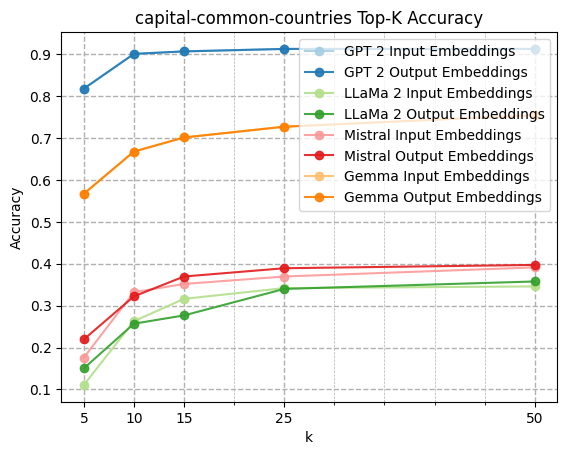

########################
capital-world
---------------------------
GPT 2 Input Rank Score: 0.31
GPT 2 Output Rank Score: 0.31
---------------------------
LLaMa 2 Input Rank Score: 0.09
LLaMa 2 Output Rank Score: 0.09
---------------------------
Mistral Input Rank Score: 0.08
Mistral Output Rank Score: 0.09
---------------------------
Gemma Input Rank Score: 0.28
Gemma Output Rank Score: 0.28


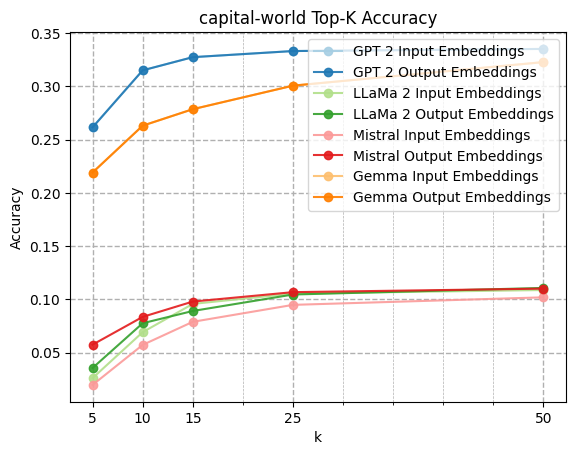

########################
currency
---------------------------
GPT 2 Input Rank Score: 0.28
GPT 2 Output Rank Score: 0.28
---------------------------
LLaMa 2 Input Rank Score: 0.14
LLaMa 2 Output Rank Score: 0.06
---------------------------
Mistral Input Rank Score: 0.17
Mistral Output Rank Score: 0.07
---------------------------
Gemma Input Rank Score: 0.06
Gemma Output Rank Score: 0.06


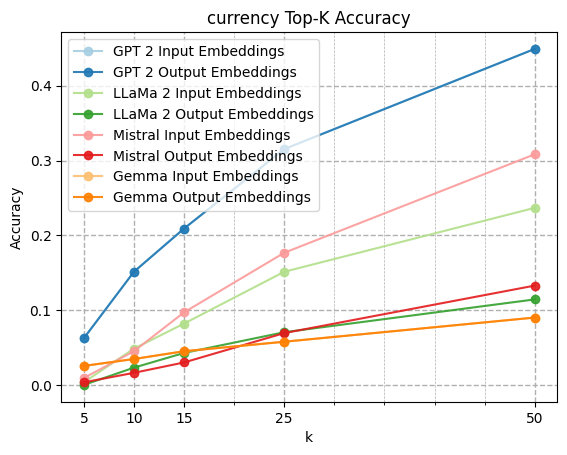

########################
city-in-state
---------------------------
GPT 2 Input Rank Score: 0.52
GPT 2 Output Rank Score: 0.52
---------------------------
LLaMa 2 Input Rank Score: 0.12
LLaMa 2 Output Rank Score: 0.17
---------------------------
Mistral Input Rank Score: 0.12
Mistral Output Rank Score: 0.22
---------------------------
Gemma Input Rank Score: 0.30
Gemma Output Rank Score: 0.30


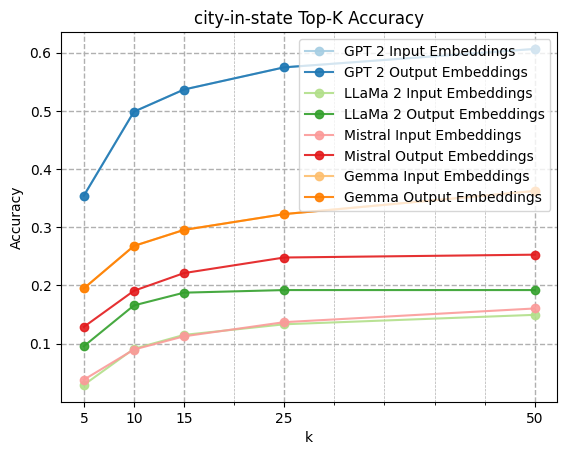

########################
family
---------------------------
GPT 2 Input Rank Score: 0.78
GPT 2 Output Rank Score: 0.78
---------------------------
LLaMa 2 Input Rank Score: 0.52
LLaMa 2 Output Rank Score: 0.44
---------------------------
Mistral Input Rank Score: 0.67
Mistral Output Rank Score: 0.61
---------------------------
Gemma Input Rank Score: 0.80
Gemma Output Rank Score: 0.80


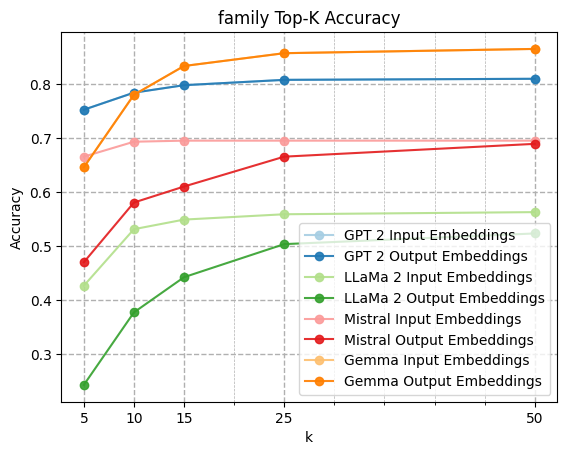

########################
gram1-adjective-to-adverb
---------------------------
GPT 2 Input Rank Score: 0.82
GPT 2 Output Rank Score: 0.82
---------------------------
LLaMa 2 Input Rank Score: 0.67
LLaMa 2 Output Rank Score: 0.67
---------------------------
Mistral Input Rank Score: 0.81
Mistral Output Rank Score: 0.81
---------------------------
Gemma Input Rank Score: 0.74
Gemma Output Rank Score: 0.74


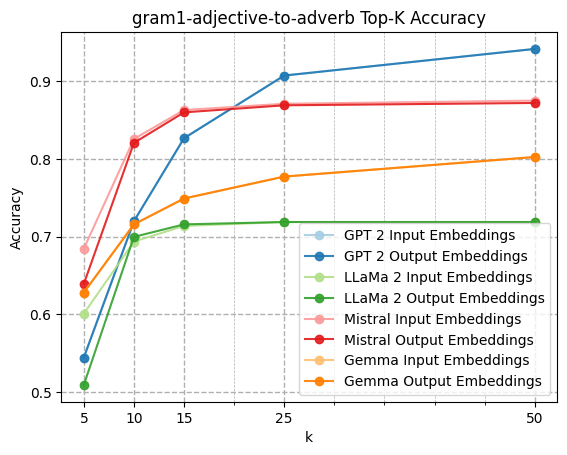

########################
gram2-opposite
---------------------------
GPT 2 Input Rank Score: 0.62
GPT 2 Output Rank Score: 0.62
---------------------------
LLaMa 2 Input Rank Score: 0.51
LLaMa 2 Output Rank Score: 0.40
---------------------------
Mistral Input Rank Score: 0.61
Mistral Output Rank Score: 0.52
---------------------------
Gemma Input Rank Score: 0.49
Gemma Output Rank Score: 0.49


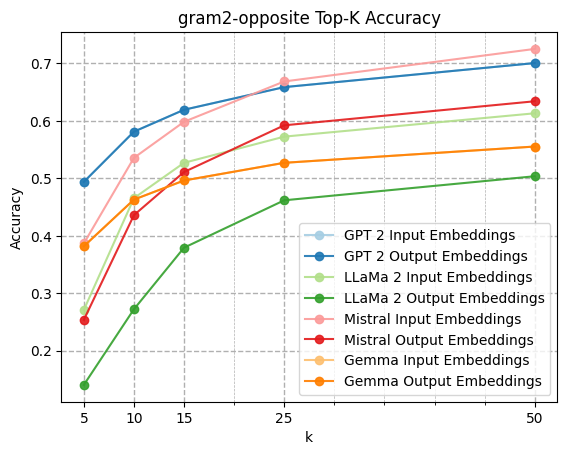

########################
gram3-comparative
---------------------------
GPT 2 Input Rank Score: 0.98
GPT 2 Output Rank Score: 0.98
---------------------------
LLaMa 2 Input Rank Score: 0.83
LLaMa 2 Output Rank Score: 0.71
---------------------------
Mistral Input Rank Score: 0.90
Mistral Output Rank Score: 0.82
---------------------------
Gemma Input Rank Score: 0.96
Gemma Output Rank Score: 0.96


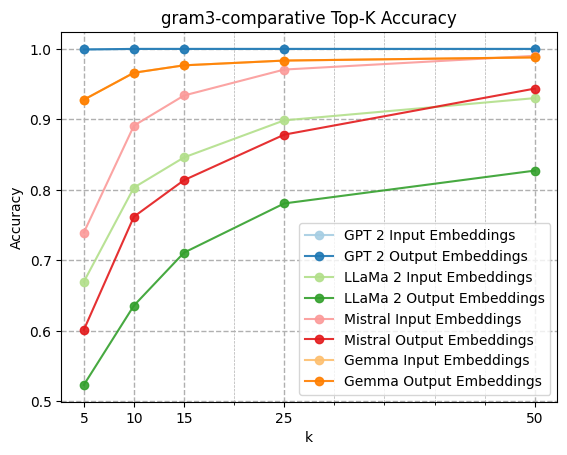

########################
gram4-superlative
---------------------------
GPT 2 Input Rank Score: 0.95
GPT 2 Output Rank Score: 0.95
---------------------------
LLaMa 2 Input Rank Score: 0.85
LLaMa 2 Output Rank Score: 0.79
---------------------------
Mistral Input Rank Score: 0.91
Mistral Output Rank Score: 0.86
---------------------------
Gemma Input Rank Score: 0.75
Gemma Output Rank Score: 0.75


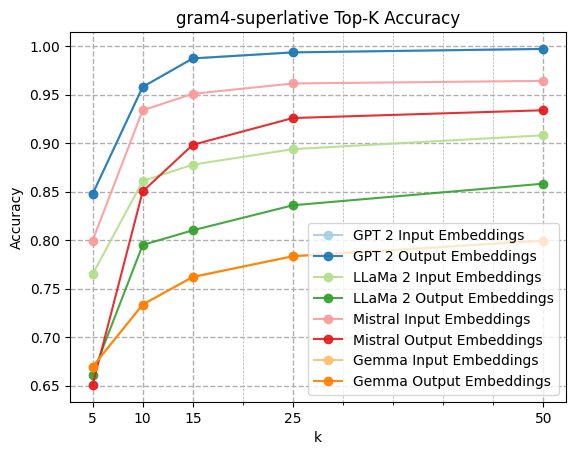

########################
gram5-present-participle
---------------------------
GPT 2 Input Rank Score: 0.97
GPT 2 Output Rank Score: 0.97
---------------------------
LLaMa 2 Input Rank Score: 0.81
LLaMa 2 Output Rank Score: 0.81
---------------------------
Mistral Input Rank Score: 0.90
Mistral Output Rank Score: 0.89
---------------------------
Gemma Input Rank Score: 0.90
Gemma Output Rank Score: 0.90


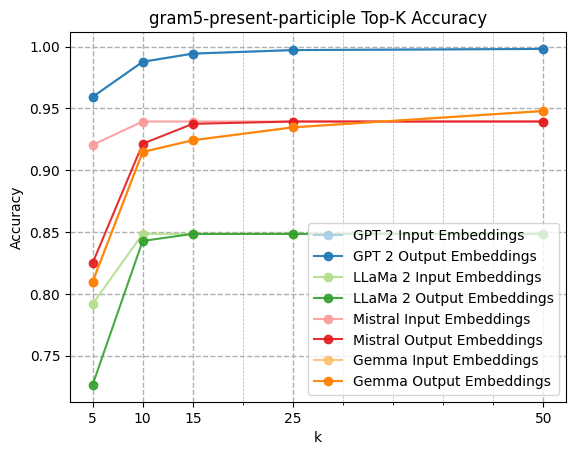

########################
gram6-nationality-adjective
---------------------------
GPT 2 Input Rank Score: 0.94
GPT 2 Output Rank Score: 0.94
---------------------------
LLaMa 2 Input Rank Score: 0.67
LLaMa 2 Output Rank Score: 0.68
---------------------------
Mistral Input Rank Score: 0.71
Mistral Output Rank Score: 0.74
---------------------------
Gemma Input Rank Score: 0.89
Gemma Output Rank Score: 0.89


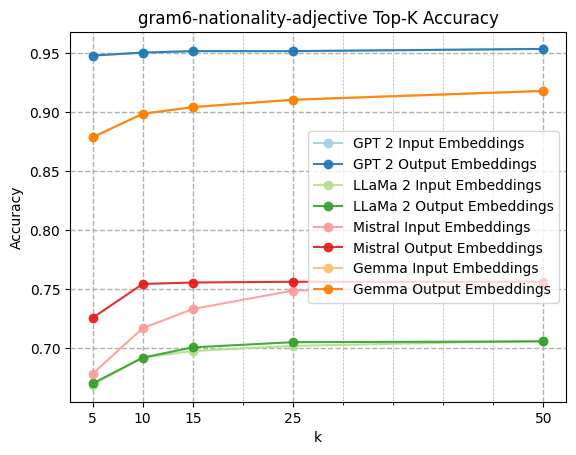

########################
gram7-past-tense
---------------------------
GPT 2 Input Rank Score: 0.95
GPT 2 Output Rank Score: 0.95
---------------------------
LLaMa 2 Input Rank Score: 0.58
LLaMa 2 Output Rank Score: 0.57
---------------------------
Mistral Input Rank Score: 0.79
Mistral Output Rank Score: 0.78
---------------------------
Gemma Input Rank Score: 0.91
Gemma Output Rank Score: 0.91


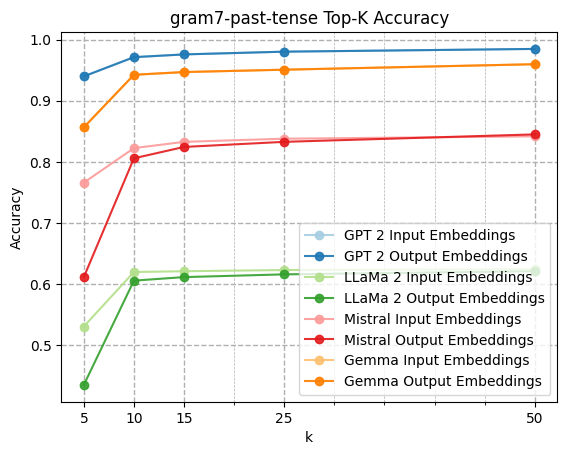

########################
gram8-plural
---------------------------
GPT 2 Input Rank Score: 0.91
GPT 2 Output Rank Score: 0.91
---------------------------
LLaMa 2 Input Rank Score: 0.52
LLaMa 2 Output Rank Score: 0.45
---------------------------
Mistral Input Rank Score: 0.62
Mistral Output Rank Score: 0.57
---------------------------
Gemma Input Rank Score: 0.97
Gemma Output Rank Score: 0.97


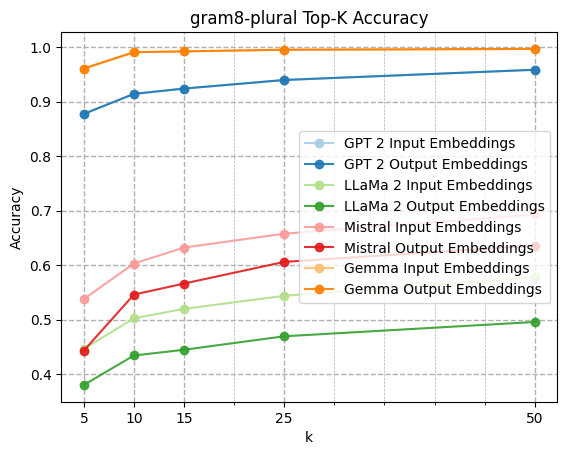

########################
gram9-plural-verbs
---------------------------
GPT 2 Input Rank Score: 0.96
GPT 2 Output Rank Score: 0.96
---------------------------
LLaMa 2 Input Rank Score: 0.73
LLaMa 2 Output Rank Score: 0.68
---------------------------
Mistral Input Rank Score: 0.81
Mistral Output Rank Score: 0.75
---------------------------
Gemma Input Rank Score: 0.89
Gemma Output Rank Score: 0.89


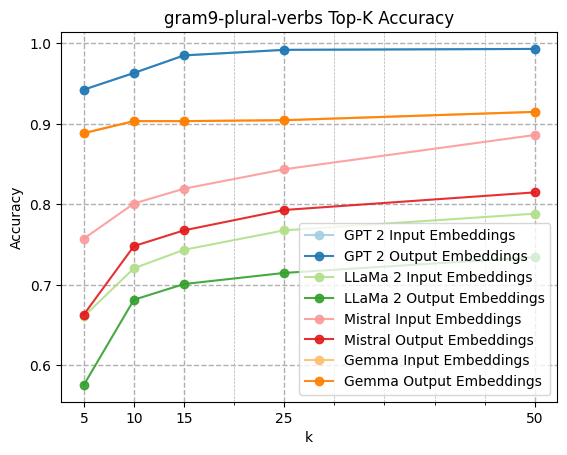

In [38]:
test_k = [5, 10, 15, 25, 50]
for category, sol in zip(data_quest.keys(),test_question_sol):
    print("########################")
    print(category)
    for model, tq, trace_idx in zip(model_info, test_questions, range(0, len(model_info)*2, 2)):
        model_name = model["name"]
        print("---------------------------")
        print(f"{model_name} Input Rank Score: {evaluate_batch(tq[0][category], sol, out=False, score='rankscore'):.2f}")
        print(f"{model_name} Output Rank Score: {evaluate_batch(tq[1][category], sol, out=False, score='rankscore'):.2f}")
        plt.plot(test_k, [evaluate_batch(tq[0][category], sol, out=False, score='topk', k=k) for k in test_k], 
                 marker='o', alpha=0.9, label=f'{model_name} Input Embeddings', c=clmp["Paired"](trace_idx))
        plt.plot(test_k, [evaluate_batch(tq[1][category], sol, out=False, score='topk', k=k) for k in test_k], 
                 marker='o', alpha=0.9, label=f'{model_name} Output Embeddings', c=clmp["Paired"]((trace_idx+1)))
        plt.xlabel('k')
        plt.ylabel('Accuracy')
        plt.xticks(test_k)
        plt.title(category + " Top-K Accuracy")
    plt.legend()
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))
    plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
    plt.grid(linestyle = '--', linewidth = 1, which="major")
    plt.savefig(f"analogy_{category}.png")
    plt.show()

In [39]:
print("Capital rankings")
for model, tok, in_emb_mod, out_emb_mod in zip(model_info, tokenizers, in_emb, out_emb):
    print("---------------------------")
    print(model["name"])
    test_format = [ [model["format"](el) for el in test] for test in capital_advanced]
    test_capital = [
        ["Input Capital", advanced_arithmetic(in_emb_mod, tok, test_format, k=100, out=False)],
        ["Output Capital", advanced_arithmetic(out_emb_mod, tok, test_format, k=100, out=False)],
    ]
    for name, result in test_capital:
        print("%%%")
        print(name)
        evaluate_batch(result, capital_advanced_sol, tok=tok, subdivide_tokens=True)

Capital rankings
---------------------------
GPT 2
%%%
Input Capital
[1, 2, 7, 2, 1, 14, 2, 1, 100, 2, 1, 1, 17] -> 0.8838461538461538
%%%
Output Capital
[1, 2, 7, 2, 1, 14, 2, 1, 100, 2, 1, 1, 17] -> 0.8838461538461538
---------------------------
LLaMa 2
%%%
Input Capital
[1, 2, 100, 100, 2, 100, 2, 1, 8, 2, 4, 1, 100] -> 0.6746153846153846
%%%
Output Capital
[6, 3, 100, 9, 7, 87, 2, 2, 20, 2, 3, 1, 100] -> 0.7369230769230769
---------------------------
Mistral
%%%
Input Capital
[1, 1, 82, 100, 1, 100, 4, 51, 15, 2, 3, 1, 100] -> 0.6453846153846154
%%%
Output Capital
[5, 1, 100, 100, 3, 94, 4, 2, 29, 1, 2, 2, 100] -> 0.6592307692307693
---------------------------
Gemma
%%%
Input Capital
[11, 6, 100, 100, 44, 100, 3, 6, 100, 4, 3, 7, 100] -> 0.5507692307692308
%%%
Output Capital
[11, 6, 100, 100, 44, 100, 3, 6, 100, 4, 3, 7, 100] -> 0.5507692307692308


In [40]:
test_questions = []
for model, tok, in_emb_mod, out_emb_mod in zip(model_info, tokenizers, in_emb, out_emb):
    test_questions.append([
        {
            category: advanced_arithmetic(in_emb_mod, tok, change_words(dataset.values.tolist(), model["format"]), k=50, out=False)
            for category, dataset in tqdm(data_quest.items())
        },
        {
            category: advanced_arithmetic(out_emb_mod, tok, change_words(dataset.values.tolist(), model["format"]), k=50, out=False)
            for category, dataset in tqdm(data_quest.items())
        },
    ])

test_question_sol = [[addall(entry) for entry in dataset.iloc[:, 1].to_list()] for dataset in data_quest.values()]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

########################
capital-common-countries
---------------------------
GPT 2 Input Rank Score: 0.90
GPT 2 Output Rank Score: 0.90
---------------------------
LLaMa 2 Input Rank Score: 0.40
LLaMa 2 Output Rank Score: 0.54
---------------------------
Mistral Input Rank Score: 0.40
Mistral Output Rank Score: 0.42
---------------------------
Gemma Input Rank Score: 0.62
Gemma Output Rank Score: 0.62


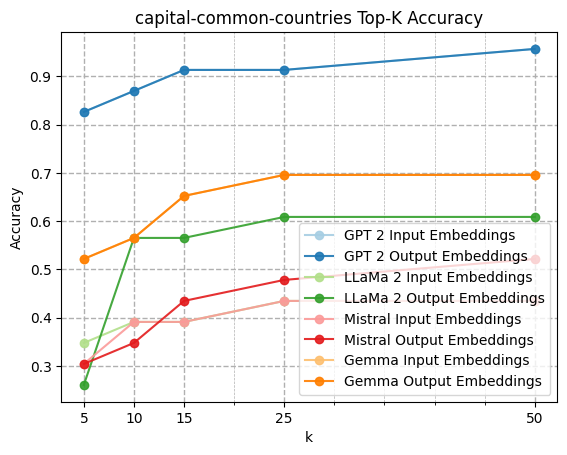

########################
capital-world
---------------------------
GPT 2 Input Rank Score: 0.49
GPT 2 Output Rank Score: 0.49
---------------------------
LLaMa 2 Input Rank Score: 0.14
LLaMa 2 Output Rank Score: 0.17
---------------------------
Mistral Input Rank Score: 0.11
Mistral Output Rank Score: 0.15
---------------------------
Gemma Input Rank Score: 0.31
Gemma Output Rank Score: 0.31


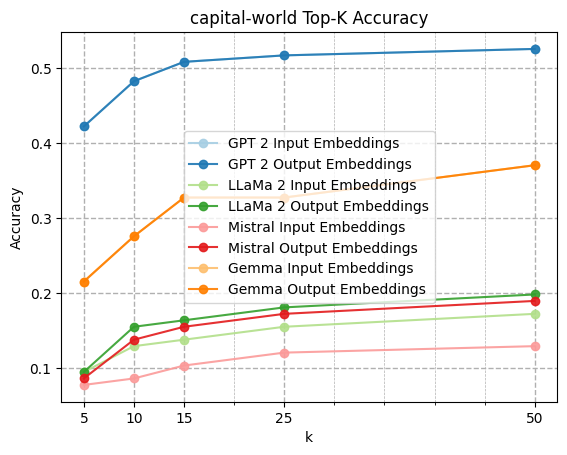

########################
currency
---------------------------
GPT 2 Input Rank Score: 0.03
GPT 2 Output Rank Score: 0.03
---------------------------
LLaMa 2 Input Rank Score: 0.00
LLaMa 2 Output Rank Score: 0.02
---------------------------
Mistral Input Rank Score: 0.00
Mistral Output Rank Score: 0.02
---------------------------
Gemma Input Rank Score: 0.00
Gemma Output Rank Score: 0.00


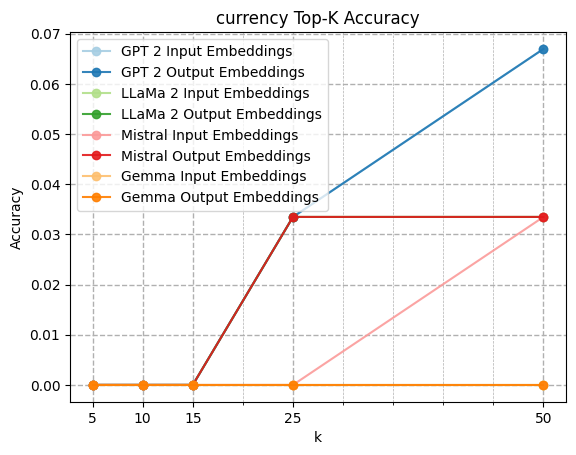

########################
city-in-state
---------------------------
GPT 2 Input Rank Score: 0.73
GPT 2 Output Rank Score: 0.73
---------------------------
LLaMa 2 Input Rank Score: 0.13
LLaMa 2 Output Rank Score: 0.25
---------------------------
Mistral Input Rank Score: 0.10
Mistral Output Rank Score: 0.25
---------------------------
Gemma Input Rank Score: 0.43
Gemma Output Rank Score: 0.43


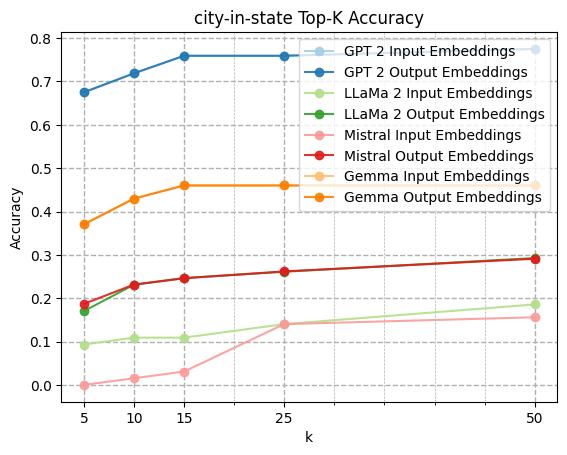

########################
family
---------------------------
GPT 2 Input Rank Score: 0.79
GPT 2 Output Rank Score: 0.79
---------------------------
LLaMa 2 Input Rank Score: 0.49
LLaMa 2 Output Rank Score: 0.42
---------------------------
Mistral Input Rank Score: 0.68
Mistral Output Rank Score: 0.63
---------------------------
Gemma Input Rank Score: 0.79
Gemma Output Rank Score: 0.79


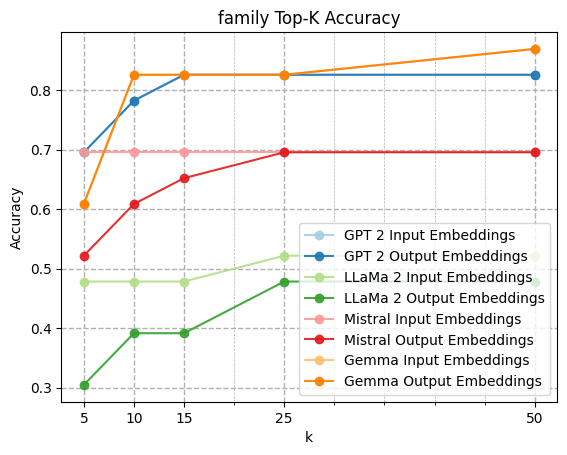

########################
gram1-adjective-to-adverb
---------------------------
GPT 2 Input Rank Score: 0.80
GPT 2 Output Rank Score: 0.80
---------------------------
LLaMa 2 Input Rank Score: 0.59
LLaMa 2 Output Rank Score: 0.60
---------------------------
Mistral Input Rank Score: 0.63
Mistral Output Rank Score: 0.66
---------------------------
Gemma Input Rank Score: 0.71
Gemma Output Rank Score: 0.71


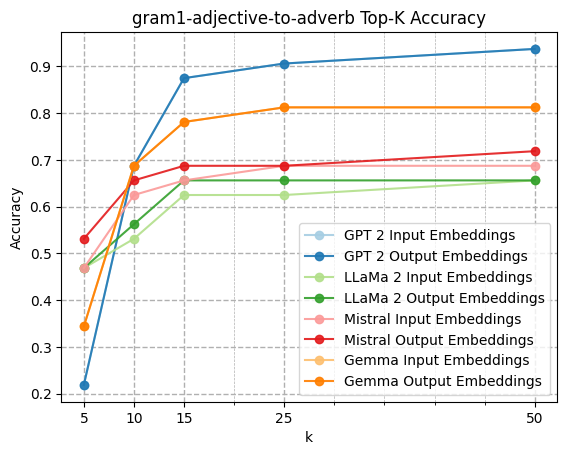

########################
gram2-opposite
---------------------------
GPT 2 Input Rank Score: 0.55
GPT 2 Output Rank Score: 0.55
---------------------------
LLaMa 2 Input Rank Score: 0.14
LLaMa 2 Output Rank Score: 0.11
---------------------------
Mistral Input Rank Score: 0.18
Mistral Output Rank Score: 0.14
---------------------------
Gemma Input Rank Score: 0.52
Gemma Output Rank Score: 0.52


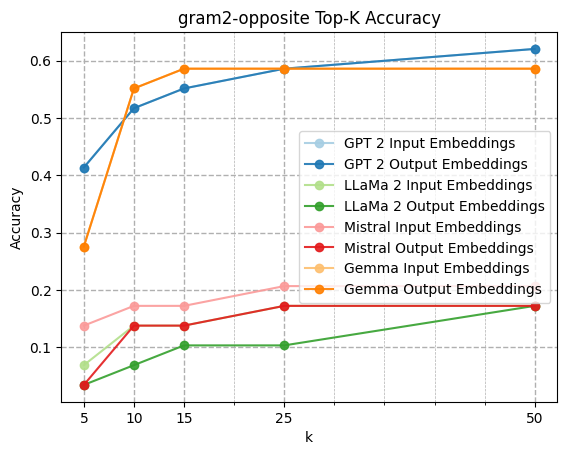

########################
gram3-comparative
---------------------------
GPT 2 Input Rank Score: 0.92
GPT 2 Output Rank Score: 0.92
---------------------------
LLaMa 2 Input Rank Score: 0.53
LLaMa 2 Output Rank Score: 0.52
---------------------------
Mistral Input Rank Score: 0.58
Mistral Output Rank Score: 0.57
---------------------------
Gemma Input Rank Score: 0.81
Gemma Output Rank Score: 0.81


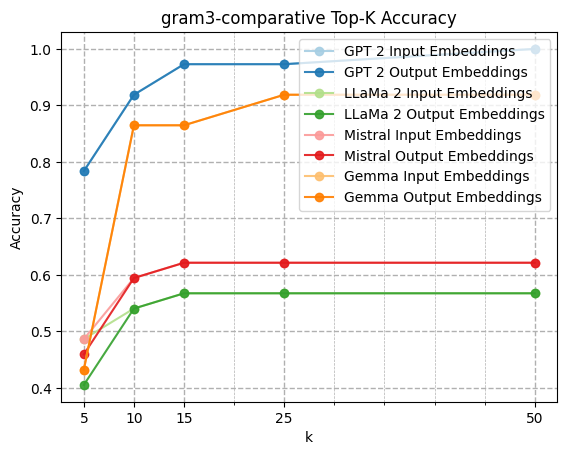

########################
gram4-superlative
---------------------------
GPT 2 Input Rank Score: 0.55
GPT 2 Output Rank Score: 0.55
---------------------------
LLaMa 2 Input Rank Score: 0.30
LLaMa 2 Output Rank Score: 0.29
---------------------------
Mistral Input Rank Score: 0.34
Mistral Output Rank Score: 0.33
---------------------------
Gemma Input Rank Score: 0.24
Gemma Output Rank Score: 0.24


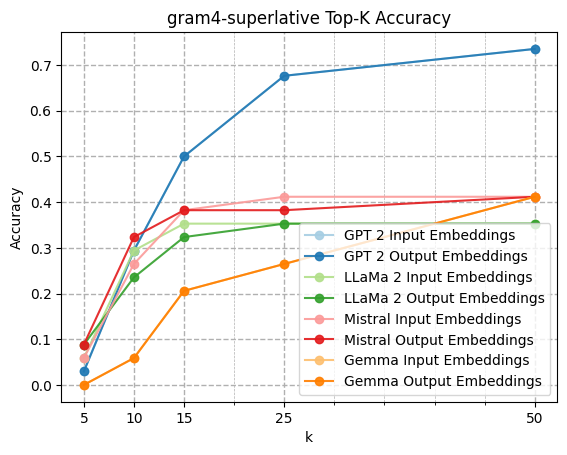

########################
gram5-present-participle
---------------------------
GPT 2 Input Rank Score: 0.87
GPT 2 Output Rank Score: 0.87
---------------------------
LLaMa 2 Input Rank Score: 0.60
LLaMa 2 Output Rank Score: 0.58
---------------------------
Mistral Input Rank Score: 0.68
Mistral Output Rank Score: 0.66
---------------------------
Gemma Input Rank Score: 0.92
Gemma Output Rank Score: 0.92


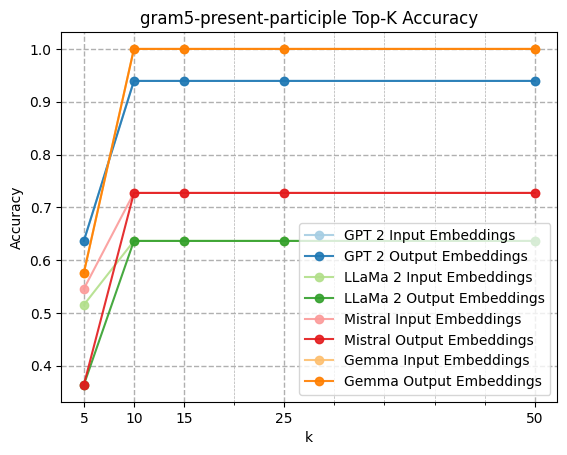

########################
gram6-nationality-adjective
---------------------------
GPT 2 Input Rank Score: 0.75
GPT 2 Output Rank Score: 0.75
---------------------------
LLaMa 2 Input Rank Score: 0.47
LLaMa 2 Output Rank Score: 0.48
---------------------------
Mistral Input Rank Score: 0.50
Mistral Output Rank Score: 0.50
---------------------------
Gemma Input Rank Score: 0.88
Gemma Output Rank Score: 0.88


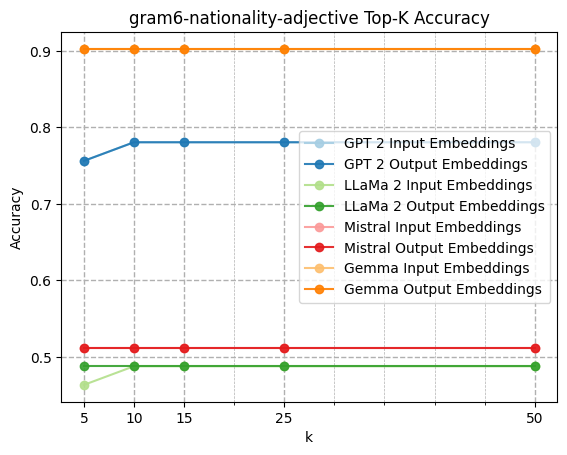

########################
gram7-past-tense
---------------------------
GPT 2 Input Rank Score: 0.85
GPT 2 Output Rank Score: 0.85
---------------------------
LLaMa 2 Input Rank Score: 0.66
LLaMa 2 Output Rank Score: 0.63
---------------------------
Mistral Input Rank Score: 0.84
Mistral Output Rank Score: 0.82
---------------------------
Gemma Input Rank Score: 0.87
Gemma Output Rank Score: 0.87


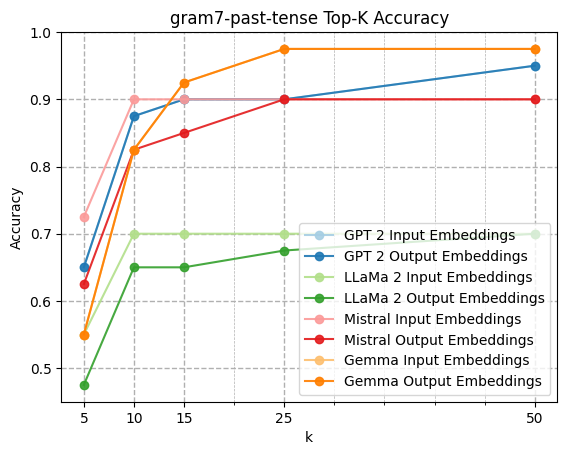

########################
gram8-plural
---------------------------
GPT 2 Input Rank Score: 0.83
GPT 2 Output Rank Score: 0.83
---------------------------
LLaMa 2 Input Rank Score: 0.44
LLaMa 2 Output Rank Score: 0.43
---------------------------
Mistral Input Rank Score: 0.52
Mistral Output Rank Score: 0.50
---------------------------
Gemma Input Rank Score: 0.90
Gemma Output Rank Score: 0.90


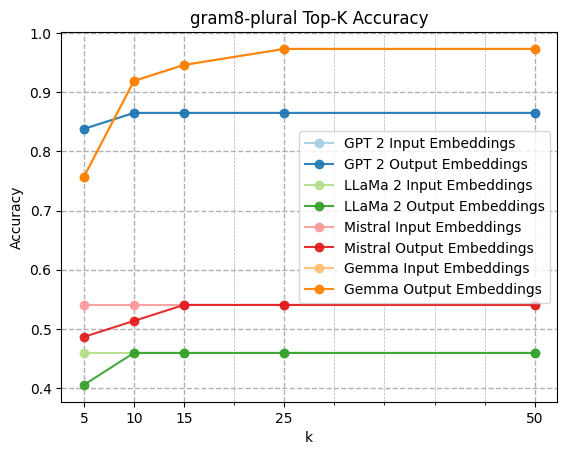

########################
gram9-plural-verbs
---------------------------
GPT 2 Input Rank Score: 0.88
GPT 2 Output Rank Score: 0.88
---------------------------
LLaMa 2 Input Rank Score: 0.48
LLaMa 2 Output Rank Score: 0.47
---------------------------
Mistral Input Rank Score: 0.57
Mistral Output Rank Score: 0.57
---------------------------
Gemma Input Rank Score: 0.93
Gemma Output Rank Score: 0.93


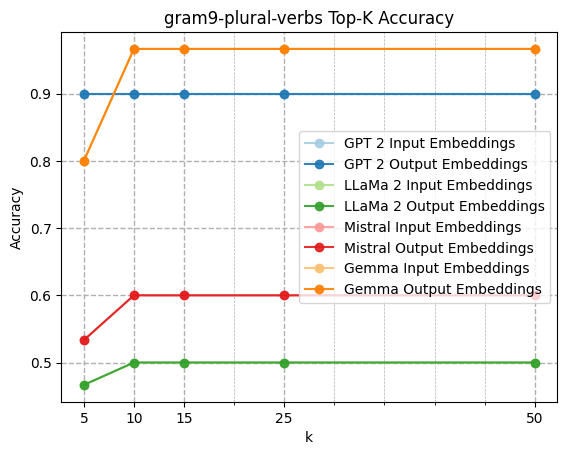

In [41]:
test_k = [5, 10, 15, 25, 50]
for category, sol in zip(data_quest.keys(),test_question_sol):
    print("########################")
    print(category)
    for model, tq, trace_idx in zip(model_info, test_questions, range(0, len(model_info)*2, 2)):
        model_name = model["name"]
        print("---------------------------")
        print(f"{model_name} Input Rank Score: {evaluate_batch(tq[0][category], sol, out=False, score='rankscore'):.2f}")
        print(f"{model_name} Output Rank Score: {evaluate_batch(tq[1][category], sol, out=False, score='rankscore'):.2f}")
        plt.plot(test_k, [evaluate_batch(tq[0][category], sol, out=False, score='topk', k=k) for k in test_k], 
                 marker='o', alpha=0.9, label=f'{model_name} Input Embeddings', c=clmp["Paired"](trace_idx))
        plt.plot(test_k, [evaluate_batch(tq[1][category], sol, out=False, score='topk', k=k) for k in test_k], 
                 marker='o', alpha=0.9, label=f'{model_name} Output Embeddings', c=clmp["Paired"]((trace_idx+1)))
        plt.xlabel('k')
        plt.ylabel('Accuracy')
        plt.xticks(test_k)
        plt.title(category + " Top-K Accuracy")
    plt.legend()
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(1))
    plt.grid(linestyle = '--', linewidth = 0.5, which="minor")
    plt.grid(linestyle = '--', linewidth = 1, which="major")
    plt.savefig(f"delta_analogy_{category}.png")
    plt.show()